# Part 1

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
from collections import Counter
import random
import time
import math
from datetime import *
from tabulate import tabulate
import matplotlib as mpl
import matplotlib.pyplot as plt
from queue import Queue

The idea we pursued to create the graph is the following:
export the data to pandas dataframes, work on the dataframes and then exploit the built in function of networkx to convert the dataframe into a graph.

In [3]:
#read the files and convert to pandas dataframe
a_q=pd.read_csv('a2q.txt.gz',sep=' ', names=['u','v','t'])  #answers to questions
c_a=pd.read_csv('c2a.txt.gz',sep=' ', names=['u','v','t'])  #comments to answers
c_q=pd.read_csv('c2q.txt.gz',sep=' ', names=['u','v','t'])  #comments to questions

In [4]:
#check they are laoded correctly
print(a_q.shape,c_a.shape,c_q.shape)

(17823525, 3) (25405374, 3) (20268151, 3)


In [5]:
#add type column to dataframes
a_q['type'] = 'a_q'
c_a['type'] = 'c_a'
c_q['type'] = 'c_q'

#add weights column initial value of 1
a_q['weight'] = 1.
c_a['weight'] = 1.
c_q['weight'] = 1.

#sort by time
a_q=a_q.sort_values('t')
c_a=c_a.sort_values('t')
c_q=c_q.sort_values('t')

In [6]:
def time_maxmin(data,min,max): #Retrieve maximum and minimum timestamps of a given dataframe
    m = data['t'].min()
    M = data['t'].max()
    if m < min:
        min = m 
    if M > max:
        max = M
    return min, max

In [7]:
def date_to_timestamp(s): #convert date in format '04 March, 2009' to timestamp
    d = datetime.strptime(s, "%d %B, %Y")
    d = datetime.timestamp(d)
    return d

In [8]:
def timestamp_to_date(timestamp): #convert timestamp to date
    d = datetime.fromtimestamp(timestamp)
    d = d.strftime("%d %B, %Y")
    return d

In [9]:
def create_graph(data1,time_window,self_loops=0): #given a pd dataframe clean values that are not in time interval and return a graph
    #remove rows with u=v if we don't want self loops
    if self_loops == 0: 
        data1 = data1[data1['u'] != data1['v']]
    
    #remove rows not having time 't' in given time interval
    data1 = data1[data1['t'].between(time_window[0], time_window[1])]
    
    #assign weight --> 1 for every edge initially, then 1/n where n is the number of times u,v interact
    #also remove multiple links bewtween 2 nodes and leave the last one in order of time
    D = data1[['u','v']]
    D = D[D.duplicated(keep=False)]
    D = D.groupby(list(D)).apply(lambda x: tuple(x.index)).tolist()
    for d in D:
        ind = list(d)
        val = len(ind)
        drop = ind[:-1]
        data1.at[ind[-1], 'weight'] = 1./float(val)
        #print(1./float(val))
        data1 = data1.drop(index = drop)
    
    #convert the dataframe into a multi directed graph with attributes of edges being: last time of interaction, type of interaction and weight of interaction
    G = nx.from_pandas_edgelist(data1, 'u', 'v', ['t', 'type', 'weight'], create_using = nx.MultiDiGraph())
    return G

In [10]:
#here we get maximum and minimum timestamps of the whole data
m = 10**(10)
M = 0
m, M = time_maxmin(a_q, m, M)
m, M = time_maxmin(c_a, m, M)
m, M = time_maxmin(c_q, m, M)
print(timestamp_to_date(m)+'; '+ timestamp_to_date(M))

01 August, 2008; 06 March, 2016


In [11]:
#obviously choose a time window that's inside (m,M)
time_window = ('04 March, 2009', '12 March, 2009')
time_window=(date_to_timestamp(time_window[0]),date_to_timestamp(time_window[1]))
#and create the graphs out of the 3 dataframes
A = create_graph(a_q, time_window)
B = create_graph(c_a, time_window)
C = create_graph(c_q, time_window)

In [12]:
#merge the graphs
G = nx.compose_all([A, B, C])

In [13]:
def drop_edges(G,time_window):#drop edges in the graph that are not in the given time interval
    to_drop=[]
    time_window=(date_to_timestamp(time_window[0]),date_to_timestamp(time_window[1]))
    
    for u,v,att in G.edges(data=True):
        if not time_window[0] <= att['t'] <= time_window[1]:
            to_drop.append((u, v))
    [G.remove_edge(u,v) for (u,v) in to_drop]
    return G

# Part 2

## 2.1

In [14]:
def get_feats(G): #Get requested features for given graph
    feats=[] 
    
    n_interactions = 0
    dir_list = []
    users=[]
    
    for u,v,attr in (G.edges(data=True)):
        if (G.has_edge(v,u)) and (n_interactions<=len(A.edges(data=True))/2) : #condition to check if graph is directed or not
            dir_list.append(abs(attr['weight']-G.get_edge_data(v, u)[0]['weight']))
        
        if u not in users: users.append(u) #update the users list
        if v not in users: users.append(v)

        n_interactions += 1 #count interactions
        
    if all(val == 0 for val in dir_list): direct=False #not directed
    else: direct=True #directed
     
    n_users = len(users) #count users
     
    avg_links = 0 #initialize values for avg links and density
    density = 0
    g = None
    if n_users>0: 
        avg_links = n_interactions/n_users #just compute a mean
        
        if direct: # we have the 2 cases for directed and undirected graph
            density = 2*n_interactions/(n_users*(n_users-1))
        else:
            density = n_interactions/(n_users*(n_users-1))
                                
        if density>0.5: #this is straightforward: we are defining a graph to be sparse if its density value<=0.5 and dense otherwise
            g='dense'
        else:
            g='sparse'
        
    #return list with asked values
    feats.extend((direct, n_users, n_interactions, avg_links, density, g))
    
    return feats

In [15]:
get_feats(G)

[True, 7075, 24819, 3.5079858657243816, 0.0009917969651468425, 'sparse']

## 2.2

### PageRank (Random surfer model)

To compure PageRank we first create the adjacency matrix of the graph, then build the $P^{RW}$ (random walk) matrix, and after that we assign $\alpha=0.2$ to create the $P$ matrix using the formula:

Given $n=\#nodes$

$P=\frac{\alpha}{n}M_1+(1-\alpha)P^{RW}$ where $M_1$ is a $nxn$ matrix filled with ones.

At this point choose a random starting node $s$ and create a vector $\vec{q}_{0}$ with all zeros except for position related to $s$, which has value 1 and iterate for a time T (T steps in a cycle) the following formula:

$\vec{q}_{t} = \vec{q}_{0} P^t$ for $t$ in $T$.

In [16]:
def build_adj_matrix(G,n): #create adjacency matrix of the graph
    if n == 0: raise('No nodes found')
    else: #we opted for doing it with a  dictionary in which we store a 1 if there is a edge between the 2 nodes
        ones = {} 
        
        for u,v in sorted(list(G.edges())):
            ones[(u,v)] = 1 
    return ones

In [17]:
def mapper(G): #return dictionary with nodes as keys and index in matrix as value
    conv={}    #maps from nodes to values in matrix, can be used in the opposite way too
    counter=0
    for u in sorted(G.nodes):
        conv[u]=counter
        counter+=1
    return conv

In [18]:
def no_tp_P(G,mat,mapper,n):
    keys = list(mat.keys())
    c = Counter(u for u,v in keys) #count number of occurances of each node, so we know by what value we have to divide to obtain P^{RW}
    for source in sorted(list(G)):
        for (u,v) in keys:
            if source == u and c[source] > 0:
                mat[(u,v)] = 1/c[source] #we divide by the value here
    keys = list(mat.keys())
    M=np.zeros(shape=(n,n)) #build ndarray (aka matrix of P^{RW}) nxn 
    for (u,v) in keys:      #fill matrix
        value=mat[(u,v)]
        i=mapper[u]
        j=mapper[v]
        #print(u,v)
        M[i][j]=value
    return M

In [19]:
def build_P(M, alpha, n): #create the P matrix from given alpha and P^{RW}
    P = (alpha/n * np.ones((n,n))) + ((1-alpha)*(M))   
    return P

In [20]:
def RandomSurfer(G, u, alpha, n, T=100): #T=time, aka n_iterations
    print('sit back and relax, this is going to take some time')
    #Build P
    mat = build_adj_matrix(G,n) 
    mapp = mapper(G)
    mat = no_tp_P(G,mat,mapp,n)
    P = build_P(mat, alpha, n)
    
    #retrieve index of given node in the matrix
    ind=mapp[u]
    
    #randomize the starting point
    start = random.randint(0,n)
    #retrieve node given its index in matrix
    key_list = list(mapp.keys())
    val_list = list(mapp.values())
    s = key_list[val_list.index(start)] #s=starting node
    
    print(('starting from node {}').format(s))
    
    #initialize vector with all zeros except 1 at starting point
    q0=np.zeros((n,1))
    q0[start]=1
    store_value=[]
    conv=False
    for t in tqdm(range(T)):
        q = np.matmul(q0.T, np.linalg.matrix_power(P, t)) #q_t=q0 * P^t
        if (t>0) and (np.array_equal(q, store_value[-1])):
            print(('converged in {} steps').format(t-1))
            q=store_value[-2] #else we are taking a all zeros array
            conv=True
            break
        store_value.append(q)
    if conv == False: print("didn't converge")
    return q[0][ind]

In [21]:
RandomSurfer(G, 1, 0.2, len(G), T=100)

sit back and relax, this is going to take some time


  0%|          | 0/100 [00:00<?, ?it/s]

starting from node 69155


100%|██████████| 100/100 [1:30:29<00:00, 54.29s/it]

didn't converge


3.1346121217268687e-09

### Closeness

Computed as

$Closeness(v)= \frac{n-1}{\sum_{u\epsilon V \setminus\{v\}}d(v,u)}$
where $d(v,u)=$ shortest path distance between (u,v).


In [22]:
def shortest_path(G,source,target):
    dist = {}
    prev = {}
    nodes_list=[]
    #Initialization
    for node in nx.nodes(G):
        dist.update({node : math.inf}) # A dict with the nodes and the distances (We initialize all the distances as + infinite)
        prev.update({node : None}) # A dict with the previous node of each node 
        nodes_list.append(node) # A list with the nodes that have not been visited
    dist[source] = 0 # We initialize the distance of the source node as 0
    
    while len(nodes_list) != 0: # We will do the next steps until we'll have visited all the nodes are we'll have found the target node
       
        # the algorithm starts visiting the node with the lower distance
        dist_list =[] 
        for node in nodes_list:
            dist_list.append(dist[node])
        u = nodes_list[dist_list.index(min(dist_list))]
        nodes_list.remove(u) # removing the node from the list of the nodes that have not been visited
        
        #If the visited node il the target stop the visits
        if u == target:
            break
            
        #Otherwise we look at the neighbors
        for neighbor in G.neighbors(u):
            #computing the new distances for all neighbors
            new_dist = dist[u] + G[u][neighbor][0]['weight']
            #If the new distance is lower than the previous one we update di distances dict
            if dist[neighbor] > new_dist:
                dist[neighbor] = new_dist
                prev[neighbor] = u
                
    #If the target has not a previous node it means that there is nott a path (the graph is not connected) so the algorithm
    #returns 'not possible'
    if prev[target] == None:
        return ('Not possible', [-1])
    
    #creating a list with the path from the source node to the target
    path_node = target
    path = [path_node]
    
    while path_node != source:
    
        path.insert(0,prev[path_node])
        path_node = prev[path_node]
    
    #The algorithm returns the distance of the target and the path
    return dist[target], path


In [23]:
def Closeness(G,u,n): #Pretty straightforward: we are just applying the formula described above
    somma=0
    for v in tqdm(G.nodes):
        dist,path=shortest_path(G,u,v)
        if (dist!='Not possible') and (dist!=0):
            somma+=int(dist)
    if somma>0: return ((n-1)/somma)
    else: raise('Error: sum=0')

In [24]:
Closeness(G,1,len(G))

100%|██████████| 7075/7075 [4:04:43<00:00,  2.08s/it]     


0.32397526906343027

### Betweenness

Computed as

$Betweenness(v)= \frac{\sum_{u,w\epsilon V \setminus\{v\}} \frac{g_{u,v}^v}{g_{u,v}}}{{n-1 \choose 2}}$

where:
* $g_{u,v}^v = $ # shortest paths between the 2 nodes (u,w) passing through v,
* $g_{u,v} = $ # shortest paths between the 2 nodes (u,w),
* $n = $ # nodes in the graph.

In [32]:
def Betweenness(G,q,n): #Pretty straightforward: we are just applying the formula described above
    print("You chose to use betweenness, we suggest you to go out and take a hangover, you'll be fine before this is over")
    somma_q = 0
    somma = 0
    for u in tqdm(G.nodes):
        for v in (G.nodes):
            dist,path = shortest_path(G,u,v)
            if (dist!='Not possible') and (dist!=0):
                somma+=dist
                if q in path:
                    somma_q+=dist
    
    num = 2*somma_q/somma
    den = n*n - 3*n + 2
    if den>0: return num/den
    else: raise('Error: denominator=0')

In [ ]:
Betweenness(G,1,len(G_B)) #We didn't run it because it takes so much time on such big graphs, but it works

In [33]:
def dist(G, u, metric, time_interval, alpha=0.2):  #return the queried metric for the given node
    G1=G.copy()
    G1=drop_edges(G1,time_interval)
    values = get_feats(G)
    n = values[1]
    if metric == 'Betweeness':
        return Betweenness(G1,u,n)
    
    elif metric == 'PageRank':
        return RandomSurfer(G1, u, alpha, n)
    
    elif metric == 'Closeness':
        return Closeness(G1,u,n)
    
    elif metric == 'Degree':
        return (G1.degree(int(u))/(n-1))
    
    else:
        raise('Metric not allowed')

In [34]:
dist(G,1,'Degree',('04 March, 2009', '05 March, 2009'))

0.0002827254735651682

## 2.3

This function computes the shortest path between each node of the sequence in order and then it returns the total shortest path. If two nodes of the sequence are disconnected it returns the string 'Not possible'.

In [35]:
def path(G,time_interval,users,source,target):
    G_new = G.copy()
    G_new = drop_edges(G_new,time_interval)
    s_p = shortest_path(G_new,source,users[0])
    dist = s_p[0]
    path = s_p[1]
    if dist == 'Not possible': #if the graph is not connected it returns 'Not possible'
        return 'Not possible'
    
    for i in range(len(users)-1):
        s_p = shortest_path(G_new,users[i],users[i+1])
        if s_p[0] == 'Not possible':
            return 'Not possible'
        dist += s_p[0]
        path.extend(s_p[1][1:])
        
    s_p = shortest_path(G_new,users[-1],target)
    if s_p[0] == 'Not possible':
            return 'Not possible'
        
    dist += s_p[0]
    path.extend(s_p[1][1:]) 
    
   
    return dist,path #it returns the total distance and the path

In [36]:
path(G,('04 March, 2009', '05 March, 2009'),[72859,1585],414876, 53055)

(3.0, [414876, 72859, 1585, 53055])

## 2.4

This function takes in input a graph, an interval of time and two users and it returns the number of link to cut to disconnect the two users. 
To disconnect the two nodes it finds the shortest path between the two nodes, it cuts the edge with the lower weight and then it restart this operations until the two nodes are disconnected (there are no more path between them).

In [37]:
def disconnect(G,time_interval,u1,u2):
    
    #Creating the graph from the interval of time
    G_tot = G.copy()  
    G_tot = drop_edges(G_tot,time_interval)
    path = shortest_path(G_tot,u1,u2)[1]
    
    #Checking if the two nodes are already disconnected
    if path == [-1]:
        return 'the two nodes are disconnected'
    
    #Initializing the weight of the links to cut, the number of links and the edges to cut
    weight = 0
    num_link = 0
    edge = (path[0],path[1])
    edges_cut = []
    #Until there are no more path between the to nodes this algorithm finds the shortest path between them and then
    #It cuts the link of the path with the lower weight
    while path != [-1]:
        min_weight = math.inf #Initializing the min weight as infinite
        
        #Finding the link of the path to cut (the one with the lower weight)
        for i in range(len(path)-1):
            j = i + 1
            if G_tot[path[i]][path[j]][0]['weight'] < min_weight:
                min_weight = G_tot[path[i]][path[j]][0]['weight']
                edge = (path[i],path[j])  
            weight += min_weight  
        #Updating the number of links to cut and the edges to cut
        num_link += 1
        edges_cut.append(edge)
        G_tot.remove_edge(*edge) #removing the edge to cut from the graph
        path = shortest_path(G_tot,u1,u2)[1]
    print('the minimum number of links to cut is ' +  str(num_link) + ' with a total weight of ' + str(weight))    
    return num_link, edges_cut #It returns the number of links to cut and the edges to cut

In [38]:
disconnect(G,('04 March, 2009', '05 March, 2009'),414876,1585)

the minimum number of links to cut is 1 with a total weight of 2.0


(1, [(414876, 72859)])

# Part 3

## 3.1

In [39]:
def create_table(features): #creates table for the output of function 1
    table=[['Directed','n_users','tot_interactions','avg links per user','Density degree','type'],features]
    print(tabulate(table,headers='firstrow'))
    return

In [40]:
def plot_degree_hist(G): #creates histogram plot for the oputput of function 1
    degrees = [G.degree(n) for n in G.nodes()]
    plt.figure(figsize=(10,5))
    plt.hist(degrees,len(G)//40,density=False)
    plt.title("Nodes' degree distribution")
    plt.xlabel("User")
    plt.ylabel("User's degree")
    plt.show()
    return


## 3.2

In [41]:
def getNeighs(G,u): #get neighbors of given node and retrieve edges between those nodes
    neigh = [v for v in G.neighbors(u)]
    neigh.append(u)
    
    edgelist=[]
    for node1 in neigh:
        for node2 in neigh:
            if (node1,node2) in G.edges:
                edgelist.append ((node1,node2))
            if (node2,node1) in G.edges:
                edgelist.append((node2,node1))
    return neigh,edgelist

In [42]:
def draw_neighs(G,u,time_interval):
    t1 = date_to_timestamp(time_interval[0])
    t2 = date_to_timestamp(time_interval[1])
    upd = (t2-t1)/3
    
    #create 3 copies of given graph top work on
    G1=G.copy()
    G2=G.copy()
    G3=G.copy()
    
    G1=drop_edges(G1,(timestamp_to_date(t1),timestamp_to_date(t1+upd)))
    G2=drop_edges(G2,(timestamp_to_date(t1),timestamp_to_date(t1+(2*upd))))
    G3=drop_edges(G3,(timestamp_to_date(t1),timestamp_to_date(t2)))
    
    neigh,edgelist = getNeighs(G1,u) 
    print(("that's what it was like until {}, with a total of {} nodes and {} edges").format(timestamp_to_date(t1+upd),len(neigh),len(edgelist)))
    plt.figure(1)
    nx.draw_networkx(G1, nodelist=neigh, edgelist=edgelist, node_size=200, width=0.5, with_labels = False, cmap='Blues', edge_cmap='Reds')
    plt.show()
    
    neigh,edgelist = getNeighs(G2,u) 
    print(("that's what it was like until {}, with a total of {} nodes and {} edges").format(timestamp_to_date(t1+ (2*upd)),len(neigh),len(edgelist)))
    plt.figure(2)
    nx.draw_networkx(G2, nodelist=neigh, edgelist=edgelist, node_size=200, width=0.5, with_labels = False, cmap='Blues', edge_cmap='Reds')
    plt.show()

    neigh,edgelist = getNeighs(G3,u)     
    print(("that's what it was like until {}, with a total of {} nodes and {} edges").format(timestamp_to_date(t2),len(neigh),len(edgelist)))
    plt.figure(3)
    nx.draw_networkx(G3, nodelist=neigh, edgelist=edgelist, node_size=200, width=0.5, with_labels = False, cmap='Blues', edge_cmap='Reds')
    plt.show()
    return

## 3.3

This function takes in input a path and draws it in a subgraph composed of the neighbors of the nodes in the graph.
The path is pointed out with the red colour.

In [43]:
def draw_path(path):  
    neigh=[]
    edgelist=[]
    edges = []
    for i in range(len(path)-1):
        edge = (path[i],path[i+1])
        edges.append(edge)
        
    #Finding the neighbors of the nodes in the path to draw the subgraph
    for node in path:
        neighbor = getNeighs(G,node)
        neigh.extend(neighbor[0])
        edgelist.extend(neighbor[1])
    
    #highlighting in red the edges of the path
    red_edges = edges
    edge_colors = ['black' if not edge in red_edges else 'red' for edge in edgelist]
    plt.figure(figsize=(8,8),dpi=80)
    width = [0.5 if not edge in red_edges else 4 for edge in edgelist]
    nx.draw(G, nodelist = neigh,pos=nx.random_layout(G), arrowsize = 15,edgelist = edgelist, node_size=150, width=width, with_labels = False, edge_color=edge_colors)
    plt.show()
    return 

## 3.4

This function takes in input a list of edges and a graph and it draws the edges in a subgraph composed of the neighbors in the nodes of the edges to cut.

In [44]:
def draw_cut_links(edges,G):    
    neigh=[]
    edgelist=[]
    
    #Finding the neighbors of the nodes in the edges to cut in order to draw the subgraph
    for el in edges:
        for node in el:
            neighbor = getNeighs(G,node)
            neigh.extend(neighbor[0])
            edgelist.extend(neighbor[1])
    edgelist.extend(edges)   
    
     
    #highlighting in red the edges to cut
    red_edges = edges
    edge_colors = ['black' if not edge in red_edges else 'red' for edge in edgelist]
    plt.figure(figsize=(8,8),dpi=80)
    width = [0.5 if not edge in red_edges else 3.5 for edge in edgelist]
    nx.draw(G, nodelist = neigh,pos=nx.spring_layout(G), arrowsize = 15,edgelist = edgelist, node_size=150, width=width, with_labels = False, edge_color=edge_colors)
    plt.show()
    return

# FUNCTIONALITIES

In [45]:
def functionality_1(G):
    feats=get_feats(G)
    print("Let's trade some of your seconds for some good looking plot")
    create_table(feats)
    plot_degree_hist(G)
    return

Let's trade some of your seconds for some good looking plot
Directed      n_users    tot_interactions    avg links per user    Density degree  type
----------  ---------  ------------------  --------------------  ----------------  ------
True             7075               24819               3.50799       0.000991797  sparse


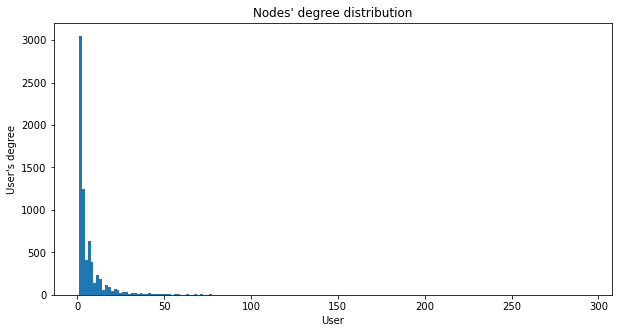

In [46]:
functionality_1(G)

In [47]:
def functionality_2(G, u, metric, time_interval, alpha=0.2):
    dist(G, u, metric, time_interval, alpha=0.2)
    print("give me few seconds and I'll show you some nice plots")
    draw_neighs(G,u,time_interval)
    return

give me few seconds and I'll show you some nice plots
that's what it was like until 05 March, 2009, with a total of 5 nodes and 8 edges


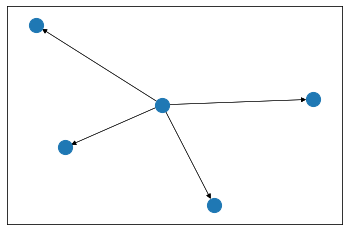

that's what it was like until 06 March, 2009, with a total of 9 nodes and 18 edges


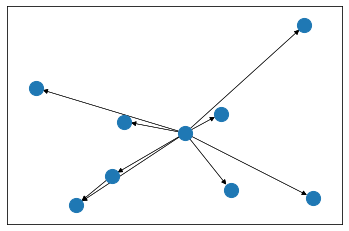

that's what it was like until 07 March, 2009, with a total of 10 nodes and 20 edges


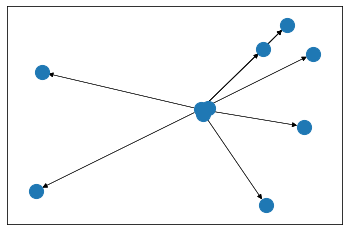

In [48]:
functionality_2(G,9345,'Degree',('04 March, 2009', '07 March, 2009'))

In [49]:
def functionality_3(G,time_interval,users,source,target):
    path_ = path(G,time_interval,users,source,target)[1]
    draw_path(path_)
    print(path_)
    return   

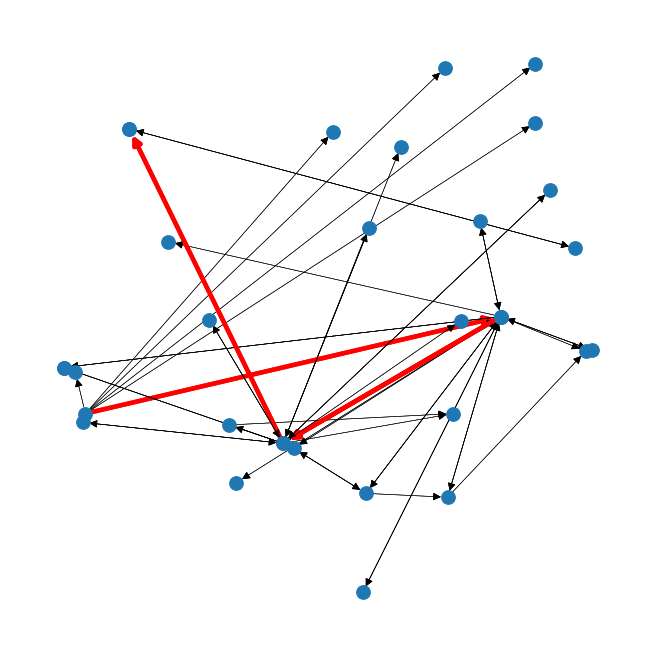

[414876, 72859, 1585, 53055]


In [50]:
functionality_3(G,('04 March, 2009', '05 March, 2009'),[72859,1585],414876, 53055)

In [51]:
def functionality_4(G,time_interval,u1,u2):
    links,edges = disconnect(G,time_interval,u1,u2)
    draw_cut_links(edges,G)
    return

the minimum number of links to cut is 1 with a total weight of 2.0


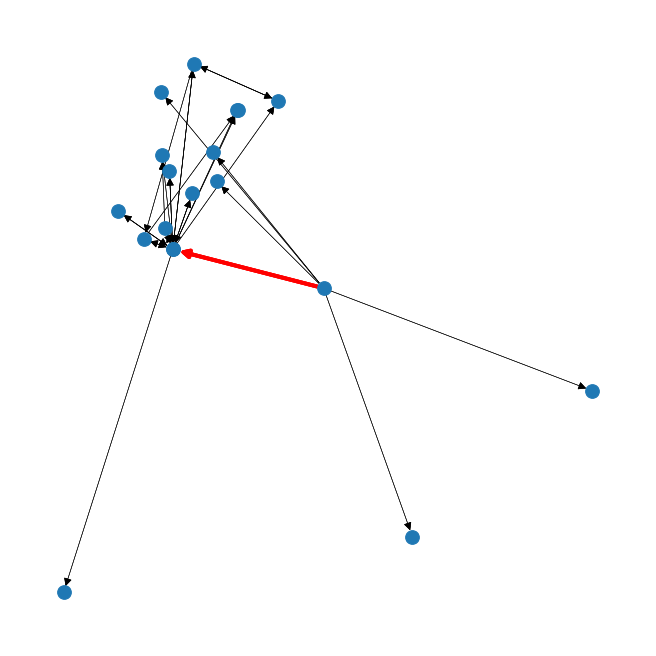

In [53]:
functionality_4(G,('04 March, 2009', '05 March, 2009'),414876,1585)

In [54]:
def program(i, G, u, metric, time_interval, users, source, target, u1, u2):
    if i=='1':
        return functionality_1(G)
    if i=='2':
        return functionality_2(G, u, metric, time_interval, alpha=0.2)
    if i=='3':
        return functionality_3(G,time_interval,users,source,target)
    if i=='4':
        return functionality_4(G,time_interval,u1,u2)

# Part 4

## 1.  Backtracking
Approach: The idea is to assign dormitory one by one to different kids, starting from the index 0. Before assigning a dormitory, check for safety by considering already assigned dormitory to the kid that fight often i.e check if the kids that fight often have the same dormitory or not. If there is any dormitory assignment that does not violate the conditions, mark the dormitory assignment as part of the solution. If no assignment of dormitory is possible then backtrack and return false.

Algorithm: 

1)Create a recursive function that takes the graph, current index, number of vertices, and output dormitory array.

2)If the current index is equal to the number of vertices. Print the kids configuration in output array.

3)Assign a dormitory to a kid (1 or 2).

4)For every assigned dormitory, check if the configuration is safe, (i.e. check if the kids that fight ofte4n do not have the same dormitory) recursively call the function with next index and number of kids

5)If any recursive function returns true break the loop and return true.

6)If no recursive function returns true then return false.

## Complexity 
#### Time Complexity: O(2^n). 
There are total O(2^n) combination of dormitory. So time complexity is O(2^n). The upperbound time complexity remains the same but the average time taken will be less.
#### Space Complexity: O(n). 
Recursive Stack of dormitoryAssignment(…) function will require O(n) space.

In [55]:
class Camp():

	def __init__(self, n,k):
		self.V = n
		self.graph = [[0 for column in range(n)]\
							for row in range(n)]

	
	def isSafe(self, v, dormitory, c):
		for i in range(self.V):
			if self.graph[v][i] == 1 and dormitory[i] == c:
				return False
		return True
	
	
	def dormitoryAssignmentUtil(self, dormitory, v, m=2):
		if v == self.V:
			return True

		for c in range(1, m + 1):
			if self.isSafe(v, dormitory, c) == True:
				dormitory[v] = c
				if self.dormitoryAssignmentUtil(m, dormitory, v + 1) == True:
					return True
				dormitory[v] = 0

	def dormitoryAssignment(self, m=2):
		dormitory = [0] * self.V
		if self.graphColourUtil(m, dormitory, 0) == None:
			return False

		
		print ("Solution exist and Following are the assigned dormitories:")
		for c in dormitory:
			print (c),
		return True




## Approach 2:  Using BFS
Lets consider every kid as a node of a graph.
The approach here is to assign a dormitory 1 to each kid from 1 to n initially. And start travelling BFS from an unvisited starting kid to cover all connected components in one go. On reaching each kid during BFS traversal, do the following:

Check all pairs of the given kid.
For each kid connected to our kid via a pair:
check if the kid fight often with our kid. If same, change the dormitory of the other kid (not the current) to 2.
check if it visited or unvisited. If not visited, mark it as visited and push it in a queue.
Check condition for maxDormitory till now. If it exceeds 2, return false
After visiting all kids, return true (As no violating condition could be found while travelling).

## Complexity Analysis:

### Time Complexity: O(n+k).
### Space Complexity: O(n). For Storing Visited List.

In [56]:
class node:
	
	dormitory = 1
	edges = set()

def canSleep(nodes, n, m=2):

	# Create a visited array of n
	# nodes, initialized to zero
	visited = [0 for _ in range(n+1)]

	# maxDormitory used till now are 1 as
	# all kids are in dormitory 1
	maxDormitory = 1

	# Do a full BFS traversal from
	# all unvisited starting points
	for i in range(1, n + 1):
		if visited[i]:
			continue

		
		visited[i] = 1
		q = Queue()
		q.put(i)

		# BFS Travel starts here
		while not q.empty():
			top = q.get()

			
			for j in nodes[top].edges:

				

				if nodes[top].fight_often == nodes[j].fight_often:
					nodes[j].color = 2

				
					
				if maxDormitory > m:
					print(maxDormitory)
					return 0

				
				if not visited[_]:
					visited[_] = 1
					q.put(_)
					
	return 1


